# Project: NFL Team Attendance Variety and Influencing Factors
# Part2: Analysis

In [10]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import warnings

warnings.simplefilter(
    action="ignore", category=FutureWarning
)  # suppress future warnings
import matplotlib.ticker as ticker

# Adjustments to the DataFrame
- add stadium_capacity to show the stadium capacity for each team.<br>
  Mainly import the data from [stadium comparison](https://www.stadiumsofprofootball.com/comparisons/). For those that moved to different stadiums, used google to fill in the missing values.
- add new columns to show the average home attendance and average home attendance rate.
- convert the 'renovated' values to 0 and 1. Value equals 1 means the stadium is renovated that year, 0 means that the stadium is not renovated that year.

In [11]:
# import the clean_data from part1
clean_data = pd.read_csv("clean_data.csv")

# import the stadium_comparison_clean from part1
stadiums = pd.read_csv("stadium_comparison_clean.csv")

# create a temporary DataFrame with only the columns needed
stadiums_capacities = stadiums[["team_name", "capacity", "year_opened"]]

# merge the two dataframes to add the stadium capacity to the clean_data
merged = pd.merge(clean_data, stadiums_capacities, on="team_name", how="left")

# rename the columns
merged = merged.rename(
    columns={"capacity": "stadium_capacity", "year_opened": "stadium_open_year"}
)

# set the capacity to None if the stadium_open_year is after the year of the game
merged["stadium_capacity"] = merged.apply(
    lambda x: x["stadium_capacity"] if x["stadium_open_year"] <= x["year"] else None,
    axis=1,
)

In [12]:
# show each team's None values in the stadium_capacity column
No_capacity = merged[merged["stadium_capacity"].isnull()][
    ["team_name", "year", "stadium_open_year", "stadium_capacity"]
]
# export the DataFrame to a csv file
No_capacity.to_csv("No_capacity.csv", index=False)

# fill in the None values with the previous capacity of the stadiums manually
# save the DataFrame with previous capacity
previous_capacity = pd.read_csv("previous_capacity.csv")
# drop the stadium_open_year column
previous_capacity = previous_capacity.drop(columns=["stadium_open_year"])
previous_capacity.head(10)
# convert the stadium_capacity column to integer
previous_capacity["stadium_capacity"] = (
    previous_capacity["stadium_capacity"].str.replace(",", "").astype(int)
)

In [13]:
# merge the two dataframes
final_dataset = pd.merge(
    merged, previous_capacity, on=["team_name", "year"], how="left"
)
# fill the missing values in the stadium_capacity column with the values from the previous_capacity column
final_dataset["stadium_capacity_x"] = final_dataset["stadium_capacity_x"].fillna(
    final_dataset["stadium_capacity_y"]
)

# drop the unnecessary columns and rename the columns
final_dataset = final_dataset.drop(
    columns=[
        "stadium_capacity_y",
        "stadium_open_year",
        "stadium_open_year",
        "stadium_renovation_year",
    ]
)
final_dataset = final_dataset.rename(columns={"stadium_capacity_x": "stadium_capacity"})
final_dataset = final_dataset.rename(columns={"total": "total_attendance"})

# convert the renovated column to 0 and 1
final_dataset["renovated"] = final_dataset["renovated"].apply(
    lambda x: 1 if x == True else 0
)

# calculate the average home attendance and the average home attendance rate
final_dataset["home_attendance_per_game"] = final_dataset["home_attendance"] / 8
final_dataset["home_attendance_rate_per_game"] = (
    final_dataset["home_attendance_per_game"] / final_dataset["stadium_capacity"]
)

# drop the total_attendance column and away_attendance column
final_dataset = final_dataset.drop(columns=["total_attendance", "away_attendance"])

In [14]:
# change the state of the Rams to Missouri and the county to St. Louis before 2016
final_dataset.loc[
    (final_dataset["team_name"] == "Rams") & (final_dataset["year"] < 2016), "state"
] = "Missouri"
final_dataset.loc[
    (final_dataset["team_name"] == "Rams") & (final_dataset["year"] < 2016), "county"
] = "St. Louis"
# change the county of the Chargers to San Diego before 2017
final_dataset.loc[
    (final_dataset["team_name"] == "Chargers") & (final_dataset["year"] < 2017),
    "county",
] = "San Diego"

In [15]:
gdpcounty_clean = pd.read_csv("gdpcounty_clean.csv")
# merge the final_dataset with the gdpcounty_clean again to adjust the gdp for the Rams and the Chargers
final_dataset = pd.merge(
    final_dataset, gdpcounty_clean, on=["state", "county", "year"], how="left"
)
final_dataset.drop(columns=["gdp_chained_million$_x"], inplace=True)
final_dataset.rename(
    columns={"gdp_chained_million$_y": "gdp_chained_million_dollar"}, inplace=True
)

# reorder the columns
final_dataset = final_dataset[
    [
        "team",
        "team_name",
        "year",
        "home_attendance",
        "wins",
        "loss",
        "playoffs",
        "superbowl_winner",
        "win_percentage",
        "state",
        "county",
        "gdp_chained_million_dollar",
        "renovated",
        "stadium_capacity",
        "home_attendance_per_game",
        "home_attendance_rate_per_game",
    ]
]

In [16]:
# brief look at the final dataset
final_dataset.head()

,team,team_name,year,home_attendance,wins,loss,playoffs,superbowl_winner,win_percentage,state,county,gdp_chained_million_dollar,renovated,stadium_capacity,home_attendance_per_game,home_attendance_rate_per_game
0,Arizona,Cardinals,2001,307315,7,9,No Playoffs,0,0.44,Arizona,Maricopa,145484.0,0,73379.0,38414.375,0.523506
1,Arizona,Cardinals,2002,327272,5,11,No Playoffs,0,0.31,Arizona,Maricopa,150559.0,0,73379.0,40909.000,0.557503
2,Arizona,Cardinals,2003,288499,4,12,No Playoffs,0,0.25,Arizona,Maricopa,160947.0,0,73379.0,36062.375,0.491454
3,Arizona,Cardinals,2004,300267,6,10,No Playoffs,0,0.38,Arizona,Maricopa,169495.0,0,71706.0,37533.375,0.523434
4,Arizona,Cardinals,2005,401035,5,11,No Playoffs,0,0.31,Arizona,Maricopa,184185.0,0,71706.0,50129.375,0.699096


In the NFL, attendance is determined not by ticket sales but by turnstile count -- the number of people who show up to watch the game, thus it may include people besides audience such as team staff and players. Therefore, the attendance rate may be higher than 1.

## Here are the real world questions we will try to answer:
<ol>
<li>To what degree does the Gross Domestic Product (GDP) of a county correlate with the attendance figures of its local sports team?</li>
<li>How significantly does the performance of a sports team, as reflected by their win-loss record, affect their game attendance numbers?
<li>Does the renovation of the stadium increase the home attendance significantly?

## Descriptive Statistics

### Description 1
Calculate the overall means, medians, modes, ranges, variance, and standard deviations of home_attendance, home_attendance_rate_per_game, win_percentage and gdp_chained_million_dollar of all teams.

In [17]:
relevant_cols = [
    "home_attendance",
    "home_attendance_rate_per_game",
    "win_percentage",
    "gdp_chained_million_dollar",
]
results = pd.DataFrame(
    index=["Mean", "Median", "Mode", "Range", "Variance", "Standard Deviation"],
    columns=relevant_cols,
)

# calculate the mean, median, mode, range, variance, and standard deviation for the relevant columns
for col in relevant_cols:
    results.at["Mean", col] = final_dataset[col].mean()
    results.at["Median", col] = final_dataset[col].median()
    mode_val = final_dataset[col].mode()
    results.at["Mode", col] = mode_val.iloc[0] if len(mode_val) == 1 else "Multiple"
    results.at["Range", col] = final_dataset[col].max() - final_dataset[col].min()
    results.at["Variance", col] = final_dataset[col].var(ddof=0)
    results.at["Standard Deviation", col] = final_dataset[col].std(ddof=0)
results

,home_attendance,home_attendance_rate_per_game,win_percentage,gdp_chained_million_dollar
Mean,537618.874363,0.959868,0.501545,101570.814516
Median,541959.0,0.979786,0.5,72950.5
Mode,550048,1.0,0.44,Multiple
Range,539088,0.79996,1.0,698358.51
Variance,3915563022.18116,0.007038,0.037406,8643752761.140303
Standard Deviation,62574.459823,0.083892,0.193406,92971.784758


#### Conclusions
**Home Attendance**

- The mean home attendance is approximately 537,619, and the median is very close to the mean (541,959). It suggests that there are not extreme outliers affecting the average.

- The range of home attendance is 539,088, whcih indicates significant variability in attendance figures among different teams. It is likely in reflecting various factors such as team performance, stadium capacity, and popularity.

- A standard deviation of home attendance is 62,574, which further confirms the considerable spread among the teams.

**Home Attendance Rate Per Game**

- Home attendance has a mean rate in 0.96 and a median rate in 0.98. It shows that on average, stadiums are nearly filled to capacity for games.

- The attandence rate has a high range of 0.8 but a low standard deviation of 0.085. It highlights that most teams have high attendance rates, but there are few outliers have significantly lower rates of home attendance.

**Win Percentage**

- Both mean and median for win percentage are around 0.5. It indicates that on average, teams win about half of their games, which shows a competitive environment.

- The win percentage has a high range of 1.0 and a low variance of 0.037. It shows the significant differences in team performances, with some teams achieving perfect seasons while others may win very few games.

**GDP (Chained in Million Dollars)**

- The mean GDP of approximately 101,571 million USD, with a significantly lower median of 72,951 million USD. It suggests a skewed distribution with some regions boasting considerably higher economic output than others.

- GDP has a substantial range of 698,358 million USD and a high standard deviation. It highlights the economic disparity among the local markets of the teams.

### Description 2
Calculate each team's means, medians, modes, ranges, variance, and standard deviations of home_attendance, home_attendance_rate_per_game, win_percentage and gdp_chained_million_dollar each year.

In [18]:
def get_mode(series: pd.Series) -> None:
    """the function returns the mode of a series if it has only one mode, and 'Multiple' if it has multiple modes. If the series has no mode, the function returns NaN."""
    mode = series.mode()
    if len(mode) > 1:
        return "Multiple"
    elif len(mode) == 1:
        return mode.iloc[0]
    else:
        return np.NaN


# calculate the mean, median, mode, range, variance, and standard deviation for the relevant columns for each team
team_overall_stats = (
    final_dataset.groupby("team_name")
    .agg(
        {
            "home_attendance": [
                "mean",
                "median",
                lambda x: get_mode(x),
                "min",
                "max",
                "var",
                "std",
            ],
            "home_attendance_rate_per_game": [
                "mean",
                "median",
                lambda x: get_mode(x),
                "min",
                "max",
                "var",
                "std",
            ],
            "win_percentage": [
                "mean",
                "median",
                lambda x: get_mode(x),
                "min",
                "max",
                "var",
                "std",
            ],
            "gdp_chained_million_dollar": [
                "mean",
                "median",
                lambda x: get_mode(x),
                "min",
                "max",
                "var",
                "std",
            ],
        }
    )
    .rename(columns={"<lambda_0>": "mode"})
)

for col in [
    "home_attendance",
    "home_attendance_rate_per_game",
    "win_percentage",
    "gdp_chained_million_dollar",
]:
    team_overall_stats[(col, "range")] = (
        team_overall_stats[(col, "max")] - team_overall_stats[(col, "min")]
    )

team_overall_stats

home_attendance                                                    \
                      mean    median      mode     min     max           var   
team_name                                                                      
49ers        550264.888889  555523.0    557856  518271  572065  2.146495e+08   
Bears        496010.555556  496626.0  Multiple  479585  535552  1.297272e+08   
Bengals      482214.000000  490311.0  Multiple  394009  527870  1.901673e+09   
Bills        537403.444444  541817.0  Multiple  490443  584122  9.064396e+08   
Broncos      608237.833333  609786.0  Multiple  599264  615517  3.322866e+07   
Browns       555194.611111  560524.5  Multiple  511060  586294  8.100180e+08   
Buccaneers   491952.777778  504274.0  Multiple  394513  525194  1.489398e+09   
Cardinals    454036.388889  495973.0  Multiple  288499  518652  7.357050e+09   
Chargers     479848.277778  518392.0  Multiple  202687  545107  8.826254e+09   
Chiefs       596342.705882  602228.0  Multiple  540114  627840  8.677004e+08   
Colts        495104.111111  513076.0  Multiple  450746  535802  1.239425e+09   
Cowboys      624306.944444  690236.5  Multiple  504717  741775  1.178025e+10   
Dolphins     546403.555556  541490.5  Multiple  459033  587787  1.384063e+09   
Eagles       548841.277778  553152.0    553152  523535  557568  1.006145e+08   
Falcons      550282.666667  561284.0  Multiple  425717  583184  1.269649e+09   
Giants       630255.722222  629861.0  Multiple  615525  643964  4.378378e+07   
Jaguars      503742.277778  515799.5  Multiple  397214  555464  1.683857e+09   
Jets         623940.555556  624568.0    625280  615656  632704  2.694227e+07   
Lions        492203.888889  491681.0  Multiple  395162  601815  1.653985e+09   
Packers      576880.166667  565707.5  Multiple  478433  627308  1.743678e+09   
Panthers     585519.777778  586784.0  Multiple  572015  592454  2.609040e+07   
Patriots     541730.444444  550048.0    550048  482336  550048  2.875451e+08   
Raiders      441166.833333  458947.0  Multiple  354276  485092  1.372744e+09   
Rams         494423.909091  507136.0  Multiple  419220  665318  2.726901e+09   
Ravens       565271.111111  568185.5  Multiple  554724  570229  2.897208e+07   
Saints       559021.833333  567358.0  Multiple  417270  585113  1.645387e+09   
Seahawks     536151.222222  543695.0  Multiple  482818  552588  3.508326e+08   
Steelers     498898.333333  501446.5  Multiple  458489  514854  1.849767e+08   
Texans       568446.647059  568643.0  Multiple  559322  574947  3.087065e+07   
Titans       543949.055556  553144.0    553144  498435  553192  2.900919e+08   
Vikings      501457.944444  511081.5  Multiple  417906  534491  1.170935e+09   

                          home_attendance_rate_per_game                      \
                      std                          mean    median      mode   
team_name                                                                     
49ers        14650.920027                      0.991422  1.000000       1.0   
Bears        11389.783793                      0.998759  1.008702  Multiple   
Bengals      43608.181545                      0.920045  0.935494  Multiple   
Bills        30107.134820                      0.938100  0.945804  Multiple   
Broncos       5764.430345                      0.998748  1.001291  Multiple   
Browns       28460.815131                      1.022157  1.031969  Multiple   
Buccaneers   38592.713964                      0.933284  0.956659  Multiple   
Cardinals    85773.249745                      0.872534  0.977865  Multiple   
Chargers     93948.143816                      0.850059  0.918340  Multiple   
Chiefs       29456.755154                      0.975487  0.985114  Multiple   
Colts        35205.461832                      0.975107  0.981711  Multiple   
Cowboys     108536.860306                      1.052335  1.078495  Multiple   
Dolphins     37203.000491                      1.045532  1.036131  Multiple   
Eagles       10030.679948 

#### Conclusions
**Home Attendance and Rate per Game**

- Teams with high mean and median home attendance figures and rates demonstrate strong fan engagement. For example, teams like the Broncos and 49ers, with high attendance figures and rates, which suggest that their games are highly anticipated events.

- Variance and standard deviation in home attendance can indicate changes in fan attendance over the years, which might be influenced by team performance and stadium renovations.

**Win Percentage**

- A mean win percentage around or above 0.5 suggests a team with competitive performance over the years.

- Teams with a lower variance in win percentage are likely experiencing consistent performance, no matter of their ranks.

**GDP (Chained in Million Dollars)**

- The mean and median GDP values reflect the economic environment of the team's region, which can influence team revenues. Teams in higher GDP areas might have more resources for player salaries, facilities, and marketing.

- A significant range in GDP for a team over the years could indicate economic growth or decline in the area, which might also affect team operations.

### Description 3
Find the number of teams that have renovated the stadium in the time period.

In [19]:
# find the number of renovation value of 1 (renovated) and 0 (not renovated)
final_dataset["renovated"].value_counts()

renovated
0    573
1     16
Name: count, dtype: int64

#### Conclusions
There are 16 teams that renovated the stadium from 2001-2018. Further inferential statistics can be applied to test whether there is a significant difference in the home_attendance_rate between renovation years and non-renovation years.

## Inferential Statistics

### Test 1: simple linear regression
- **independent variable(x)**: win_percentage
- **dependent variable(y)**: home_attendance_rate_per_game
- **null hypothesis**: there is not a statistically significant relationship between win_percentage and home_attendance_rate_per_game.
- **alternative hypothesis**: there is a statistically significant relationship between win_percentage and home_attendance_rate_per_game.
- **significance level**: 0.05

In [20]:
# check the correlation between the winnning percentage and the home attendance rate
final_dataset[["win_percentage", "home_attendance_rate_per_game"]].corr()

,win_percentage,home_attendance_rate_per_game
win_percentage,1.000000,0.173828
home_attendance_rate_per_game,0.173828,1.000000


There's a weak positive correlation between the winning percentage and the home attendance rate per game.

In [21]:
# build a regression model between home_attendance_rate_per_game and winning percentage
model1 = smf.ols(
    "home_attendance_rate_per_game ~ win_percentage", data=final_dataset
).fit()
print(model1.summary())

                                  OLS Regression Results                                 
Dep. Variable:     home_attendance_rate_per_game   R-squared:                       0.030
Model:                                       OLS   Adj. R-squared:                  0.029
Method:                            Least Squares   F-statistic:                     18.29
Date:                           Tue, 19 Mar 2024   Prob (F-statistic):           2.21e-05
Time:                                   14:44:10   Log-Likelihood:                 632.95
No. Observations:                            589   AIC:                            -1262.
Df Residuals:                                587   BIC:                            -1253.
Df Model:                                      1                                         
Covariance Type:                       nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------

#### Conclusion 1
- The fitted linear regression model is home_attendance_rate_per_game = 0.9194 + 0.0865*(win_percentage)
- R-squared value = 0.047: 4.7% of the variance in home_attendance_rate_per_game can be explained by the win_percentage using the regression model. It also becomes evident that this regression model has a limited ability to accurately predict or represent the relationship between these two variables, suggesting it is not a good fit for the data.
- p-value = 0.0000: p-value is less than 0.05, which means that we can **reject the null hypothesis**. We confirm that **there is a statistically significant relationship** between win_percentage and home_attendance_rate_per_game.

#### The multiple regression will be applied in the multivariate analysis part.

### Test 2: Anova Test1
- categorize the win_percentage into 3 groups.
- **null hypothesis**: there is no statistically significant difference in home_attendance_rate_per_game between different win_percentage_category.
- **alternative hypothesis**: there is a statistically significant difference in home_attendance_rate_per_game between different win_percentage_category.
- **significance level**: 0.05

In [22]:
# categorize the winning percentage into 3 categories
final_dataset["win_percentage_category"] = pd.qcut(
    final_dataset["win_percentage"], q=3, labels=["low", "medium", "high"]
)

# calculate the average home attendance rate for each category
final_dataset.groupby("win_percentage_category")["home_attendance_rate_per_game"].mean()

win_percentage_category
low       0.941853
medium    0.973947
high      0.972929
Name: home_attendance_rate_per_game, dtype: float64

In [23]:
# run an ANOVA test to check if the average home attendance rate is different for the three categories
model2 = smf.ols(
    "home_attendance_rate_per_game ~ C(win_percentage_category)", data=final_dataset
).fit()
anova_table = sm.stats.anova_lm(model2, typ=2)
print(anova_table)

                              sum_sq     df          F    PR(>F)
C(win_percentage_category)  0.145021    2.0  10.621928  0.000029
Residual                    4.000312  586.0        NaN       NaN


#### Conclusion 2
-p-value: p-value is less than 0.05, which means we **can reject the null hypothesis**. It is confirmed that **there is a statistically significant difference** among home_attendance_rate_per_game between different win_percentage_category.

### Test 3: Anova Test2
- categorize the gdp_chained_million_dollar into four groups.
- **null hypothesis**: there is no statistically significant difference among home_attendance_rate_per_game between different gdp groups.
- **alternative hypothesis**: there is statistically significant difference among home_attendance_rate_per_game between different gdp groups.
- **significance level**: 0.05

In [24]:
# categorize the gdp_chained_million_dollar into 4 categories
final_dataset["gdp_category"] = pd.qcut(
    final_dataset["gdp_chained_million_dollar"],
    4,
    labels=["Low", "Medium", "High", "Very High"],
)

# calculate the mean home_attendance_rate for each gdp_category
final_dataset.groupby("gdp_category")["home_attendance_rate_per_game"].mean()

gdp_category
Low          0.956846
Medium       0.955731
High         0.971488
Very High    0.955429
Name: home_attendance_rate_per_game, dtype: float64

In [25]:
# run a Anova test to check if the gdp_category has an effect on the home_attendance_rate_per_game
model2 = smf.ols(
    "home_attendance_rate_per_game ~ C(gdp_category)", data=final_dataset
).fit()

anova_table = sm.stats.anova_lm(model2, typ=2)
print(anova_table)

                   sum_sq     df         F    PR(>F)
C(gdp_category)  0.026613    3.0  1.259994  0.287273
Residual         4.118720  585.0       NaN       NaN


#### Conclusion 3
- p-value = 0.219: p-value is greater than 0.05, which means we **don't have enough evidence to reject the null hypothesis**. It is confirmed that there is **no statistically significant difference** among home_attendance_rate_per_game between different GDP groups.

### Test 4: Chi-square Test1
- Categorize the home_attendance_per_game into low, medium, and high.
- **null hypothesis**: there is no significant relationship between home_attendance_categories and stadium renovation.
- **alternative hypothesis**: there is a significant relationship between home_attendance_categories and stadium renovation.
- **significance level**: 0.05

In [26]:
# Categorize the home_attendance_per_game into low, medium, and high
final_dataset["home_attendance_categories"] = pd.qcut(
    final_dataset["home_attendance_per_game"], q=3, labels=["low", "medium", "high"]
)

# use chi-square test to see if there is a significant relationship between home_attendance_categories and renovated
contingency_table = pd.crosstab(
    final_dataset["home_attendance_categories"], final_dataset["renovated"]
)
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print(f"Chi-square Statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")

Chi-square Statistic: 0.13217919270320622
P-value: 0.9360469941388412
Degrees of Freedom: 2


#### Conclusion 4
- Chi-square (χ²) value: 0.1326. The chi-square suggests that there is a little variation between the observed and expected frequencies.
P-value: 0.9358. This is well above the common significance level of 0.05, indicating that the observed association could very likely be due to random chance.

In conclusion, there is **no evidence** to suggest a significant association between stadium renovation and home attendance categories in the context of the data.


### Test 5: Chi-square Test2
- **null hypothesis**: there is no significant relationship between home_attendance_categories and superbowl_winner.
- **alternative hypothesis**: there is a significant relationship between home_attendance_categories and superbowl_winner.
- **significance level**: 0.05

In [27]:
# Apply chi-square test to see if there is a significant relationship between home_attendance_categories and superbowl_winner
contingency_table = pd.crosstab(
    final_dataset["home_attendance_categories"], final_dataset["superbowl_winner"]
)
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print(f"Chi-square Statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")

Chi-square Statistic: 2.0902974895541973
P-value: 0.35163951094718543
Degrees of Freedom: 2


#### Conclusion 5
The chi-square statistic of 2.09 with 2 degrees of freedom is not statistically significant, as indicated by the p-value of 0.296. This p-value is higher than the conventional threshold of 0.05, which suggests that there is **no evidence** of an association between the categories of home attendance and winning the Super Bowl in the dataset. In other words, based on this test, we cannot conclude that the distribution of home attendance categories differs for teams that won the Super Bowl compared to those that did not.

## Graphical Analysis

Create various types of plots to visualize relationships within your data. Use histograms, bar charts, scatter plots, box plots, and any other suitable graphical representations you've learned.

Be sure to use appropriate titles, labels, and legends to make your plots readable and informative.

Interpret the graphical representations to uncover patterns, trends, and outliers.


### Steps
- draw regression plots between between winning_percentage and home_attendance_rate_per_game, gdp_chained_million$ and home_attendance_rate per game.
- draw box plots for the home_attendance_rate_per_gamer in two groups, the renovated year and the year before.

### Graphical Analysis 1: home_attendance_rate_per_game & win_percentage and home_attendance_rate_per_game & win_percentage_category

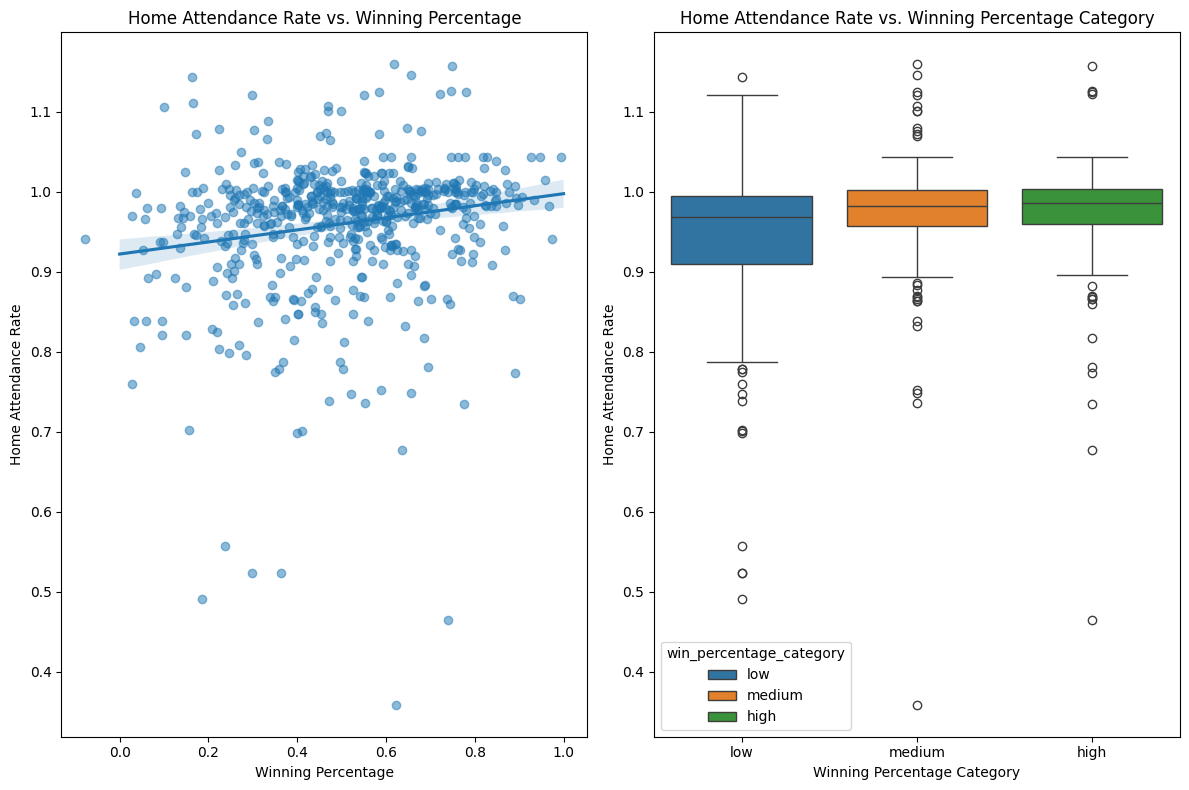

In [28]:
# draw the regression plot and boxplot
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

sns.regplot(
    x="win_percentage",
    y="home_attendance_rate_per_game",
    data=final_dataset,
    ax=ax1,
    x_jitter=0.1,
    scatter_kws={"alpha": 0.5},
)
ax1.set_title("Home Attendance Rate vs. Winning Percentage")
ax1.set_xlabel("Winning Percentage")
ax1.set_ylabel("Home Attendance Rate")

sns.boxplot(
    x="win_percentage_category",
    y="home_attendance_rate_per_game",
    data=final_dataset,
    ax=ax2,
    hue="win_percentage_category",
    legend=True,
)
ax2.set_title("Home Attendance Rate vs. Winning Percentage Category")
ax2.set_xlabel("Winning Percentage Category")
ax2.set_ylabel("Home Attendance Rate")

plt.tight_layout()
plt.show()

According to the regression plot, there is a weak positive relationship between home attendance rate and winning percentage, which corresponds to the result of the simple regression model. There are several outliers with an extremely low home attendance rate in the graph. When it comes to the boxplot, it can be inferred that the home attendance rate is the highest in the high winning percentage category. In the low category, there are outliers with a very low home attendance rate, while there are outliers with a very high home attendance rate in the high winning percentage category. The differences in the boxplot correspond with the result of the ANOVA test.

### Graphical Analysis 2: Distribution of home_attendance_rate in different gdp categories

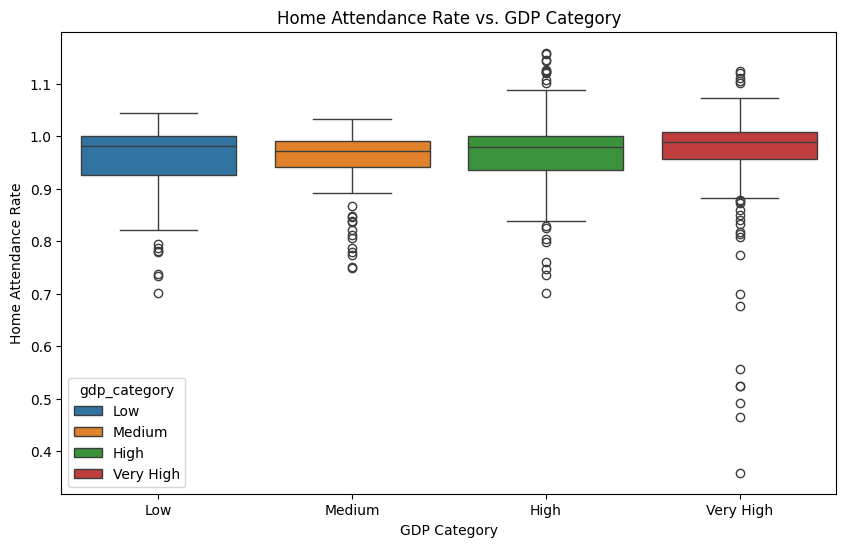

In [29]:
# draw the boxplot for the home_attendance_rate_per_game and the gdp_category
plt.figure(figsize=(10, 6))
sns.boxplot(
    x="gdp_category",
    y="home_attendance_rate_per_game",
    data=final_dataset,
    hue="gdp_category",
    legend=True,
)
plt.title("Home Attendance Rate vs. GDP Category")
plt.xlabel("GDP Category")
plt.ylabel("Home Attendance Rate")
plt.show()

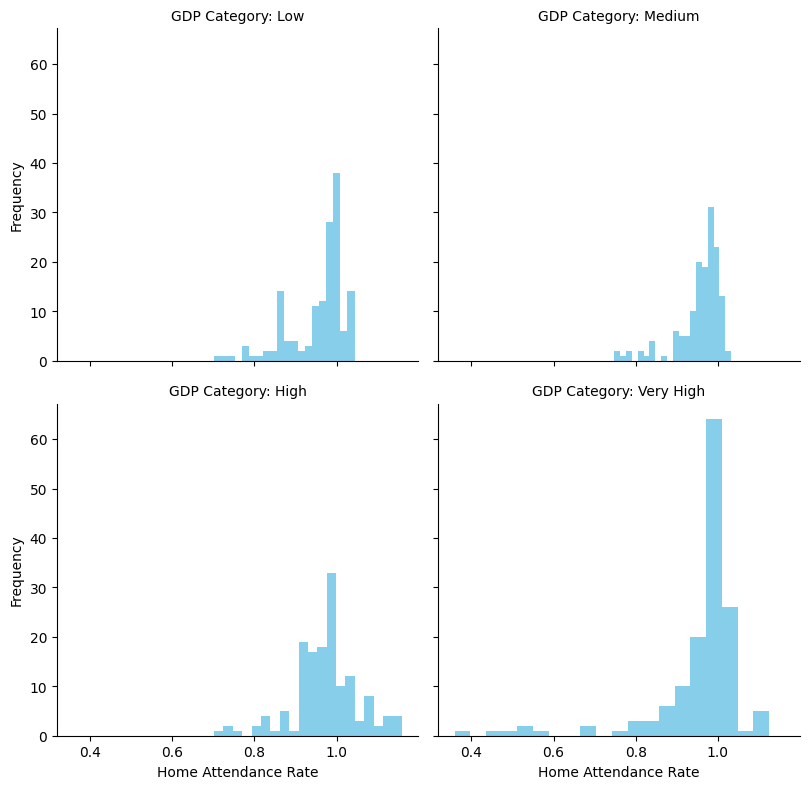

In [30]:
# draw the histogram for the home_attendance_rate_per_game in each gdp_category
g = sns.FacetGrid(final_dataset, col="gdp_category", col_wrap=2, height=4)
g.map(plt.hist, "home_attendance_rate_per_game", bins=20, color="skyblue")
g.set_axis_labels("Home Attendance Rate", "Frequency")
g.set_titles("GDP Category: {col_name}")
plt.show()

According to the boxplot and histograms, the difference in home attendance rates between different GDP categories is not obvious. In fact, the median home attendance rate of the low-gap category is even higher than that of the medium and high categories. However, the home attendance rate in the "Very High" GDP category remains the highest among the four groups. And it can be inferred from the histograms that there are most home attendance rates around 1.0 in the "Very High" GDP category.

## Comparative Analysis

Compare and contrast different subsets of your data. This can include comparisons over time, across different categories, or any other relevant segmentation.  Note that for some projects, the nature of this comparative analysis will be obvious.  For others, you will need to think about how you might subset your data.

Discuss any notable similarities or differences you have identified.


### Steps
- group by team, analyze each team's attendance, winning_percentage and gdp over years (line plot?). And find out whether there is similar trend.
- group by year, look at the distribution of team's attendance, winning_percentage and gdp each year.

### Comparative Analysis 1: Comparison between the Texans and Titans

In [31]:
# calculate the correlation for each team and sort the results
team_correlations = (
    final_dataset.groupby("team_name")
    .apply(
        lambda x: x["home_attendance_rate_per_game"].corr(
            x["gdp_chained_million_dollar"]
        )
    )
    .sort_values()
)

# get the teams with the highest and lowest correlation
highest_correlation_team = team_correlations.idxmax()
lowest_correlation_team = team_correlations.idxmin()

# print the results
print(
    f"Team with the highest correlation: {highest_correlation_team} ({team_correlations[highest_correlation_team]})"
)
print(
    f"Team with the lowest correlation: {lowest_correlation_team} ({team_correlations[lowest_correlation_team]})"
)

Team with the highest correlation: Texans (0.8931544736429564)
Team with the lowest correlation: Chargers (-0.9459238970989667)


Choosing two teams, the Texans and Titans, one with the highest correlation and one with the lowest correlation between home attendance rate per game and GDP (measured in chained million dollars), serves a strategic purpose in our analysis to explore and compare the range of possible relationships between the variables across different contexts.

In [32]:
# Analyze the team's attendance, win_percentage and GDP over year from Texans and Titans
team = final_dataset[
    (final_dataset["team_name"] == "Texans")
    | (final_dataset["team_name"] == "Titans")
]
average_home_attendance_rate = (
    team.groupby(["team_name", "year"])["home_attendance_rate_per_game"]
    .mean()
    .reset_index()
)
average_winning_percentage = (
    team.groupby(["team_name", "year"])["win_percentage"].mean().reset_index()
)
average_gdp = (
    team.groupby(["team_name", "year"])["gdp_chained_million_dollar"]
    .mean()
    .reset_index()
)

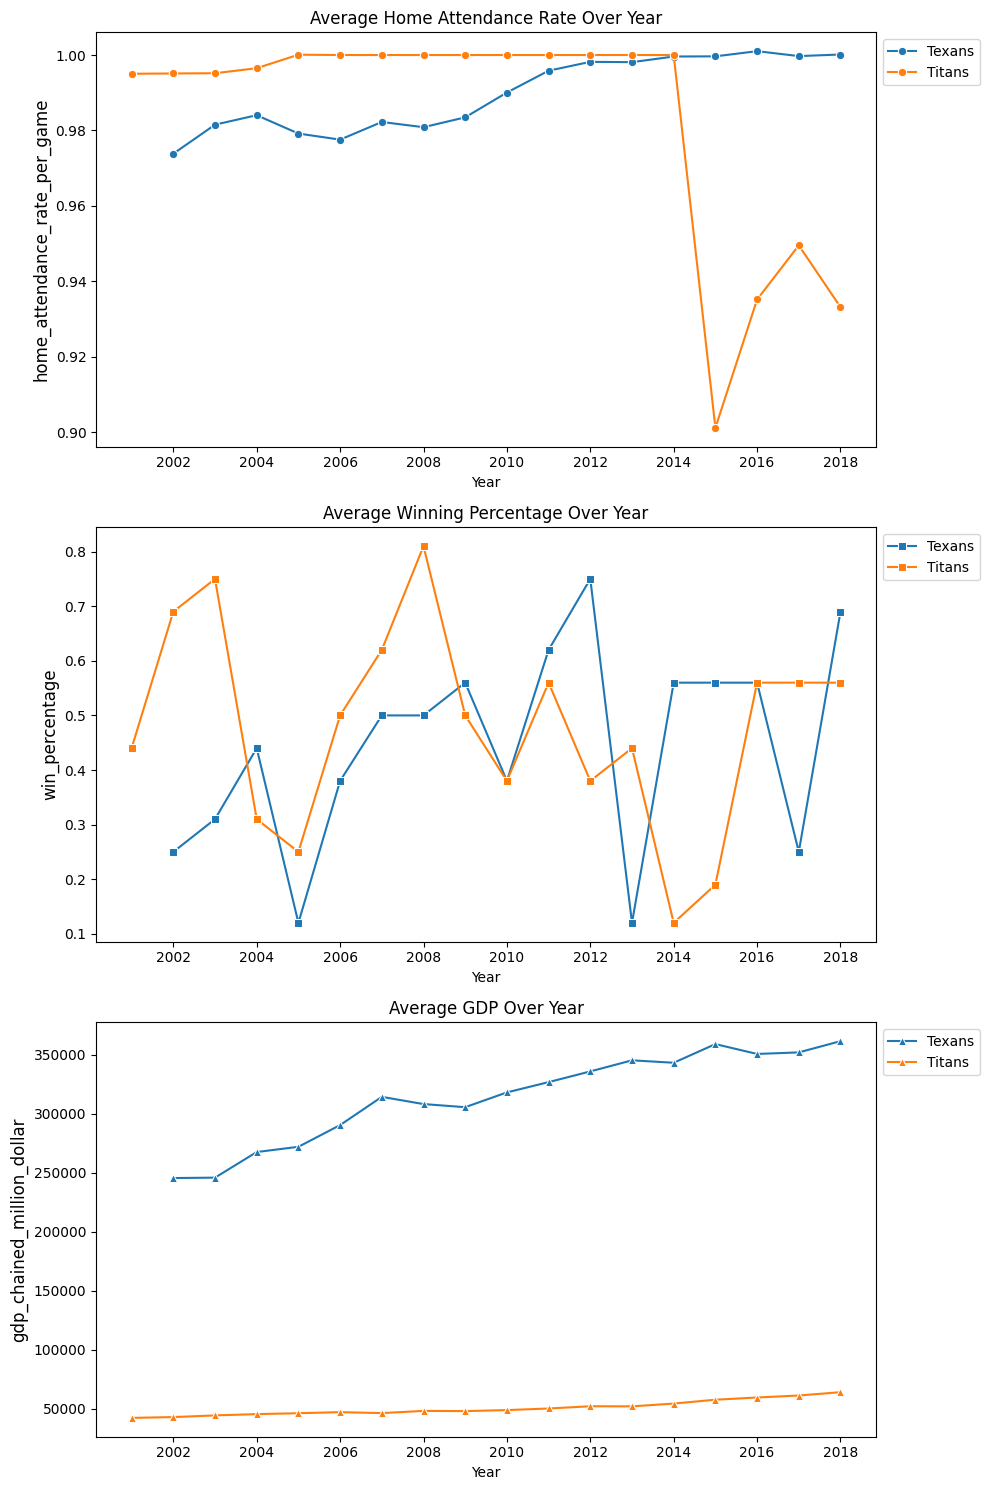

In [33]:
# Graph for average home attendance rate, winning percentage, and gdp over year for Texans and Titans
def plot_graphs(data):
    fig, ax = plt.subplots(3, 1, figsize=(10, 15))  # Increase figure size
    for axis in ax:
        # Set x-ticks to be integer values
        axis.xaxis.set_major_locator(
            ticker.MaxNLocator(integer=True)
        )  # Referenced from GEN AI to set x-ticks to be integer values

    # Home Attendance Rate
    sns.lineplot(
        data=data["average_home_attendance_rate"],
        x="year",
        y="home_attendance_rate_per_game",
        hue="team_name",
        ax=ax[0],
        marker="o",
    )
    ax[0].set_title("Average Home Attendance Rate Over Year")
    ax[0].legend(
        loc="upper left", bbox_to_anchor=(1, 1)
    )  # Move the legend to the right

    # Winning Percentage
    sns.lineplot(
        data=data["average_winning_percentage"],
        x="year",
        y="win_percentage",
        hue="team_name",
        ax=ax[1],
        marker="s",
    )
    ax[1].set_title("Average Winning Percentage Over Year")
    ax[1].legend(
        loc="upper left", bbox_to_anchor=(1, 1)
    )  # Move the legend to the right

    # GDP
    sns.lineplot(
        data=data["average_gdp"],
        x="year",
        y="gdp_chained_million_dollar",
        hue="team_name",
        ax=ax[2],
        marker="^",
    )
    ax[2].set_title("Average GDP Over Year")
    ax[2].legend(
        loc="upper left", bbox_to_anchor=(1, 1)
    )  # Move the legend to the right

    for axis in ax:
        axis.set_xlabel("Year")  # Set x-axis label
        axis.set_ylabel(
            axis.get_ylabel(), fontsize=12
        )  # Set y-axis label with larger font
        axis.tick_params(
            axis="both", which="major", labelsize=10
        )  # Set larger tick labels

    plt.tight_layout()
    plt.show()


# call the function to plot the graphs
plot_graphs(
    {
        "average_home_attendance_rate": average_home_attendance_rate,
        "average_winning_percentage": average_winning_percentage,
        "average_gdp": average_gdp,
    }
)

**Summary of comparative analysis for Titans and Texans**

**1. Average Home Attendance Rate Over Year**

The Texans consistently maintain a high home attendance rate, with a slight increase over time, suggesting strong fan loyalty or consistent team performance that draws viewers. Notably, their attendance rate does not fluctuate significantly with changing win percentages. In contrast, the Titans have a more volatile home attendance rate, with initial stability then experiencing significant fluctuations. There is a dramatic drop around 2016, suggesting a possible issue that year, such as poor performance or other factors deterring attendance.

**2. Average Winning Percentage Over Year**

Both teams show fluctuations in their winning percentages over the years, with no clear upward or downward trend. The Titans have had some years with very high win percentages, but these peaks do not seem to directly correlate with consistent attendance rates. This could suggest that, for the Titans, other factors may influence attendance more than win rates. The Texans' win rates also fluctuate, but the impact on attendance is less clear from these graphs alone. It would require a deeper analysis to determine if there's a correlation with other variables, such as economic factors or team performance, in relation to attendance.

**3. Average GDP Over Year**

The Titans' GDP remains relatively stable over the observed period with no significant increases or decreases, which contrasts with the more volatile attendance and winning percentage rates, indicating that the local GDP may not be a primary factor affecting the team's attendance rates. On the other hand, the Texans' GDP shows a consistent upward trend, suggesting a growing local economy. This upward trend in GDP could be a contributing factor to the Texans' stable home attendance rates, hinting at a possible correlation between economic conditions and attendance for the Texans, but not necessarily for the Titans.

**Overall conclusion**

The analysis of the graphs indicates contrasting relationships between the home attendance rates, winning percentages, and GDP growth for the Texans and the Titans. The Texans display a stable attendance rate, potentially influenced by steady GDP growth, suggesting that economic factors may play a role in their fan turnout. In contrast, the Titans experience stable GDP growth that does not correlate with their fluctuating attendance rates, indicating that economic stability does not necessarily guarantee higher attendance rates, and other factors may be influential. Both teams exhibit fluctuating winning percentages, but these do not consistently impact attendance rates, implying that a variety of additional variables may influence game attendance.

In [34]:
# Find three teams in the same state
final_dataset[final_dataset["state"] == "Florida"]["team_name"].unique()

array(['Jaguars', 'Dolphins', 'Buccaneers'], dtype=object)

### Comparative Analysis 2: Comparison between the Jaguars, Dolphins, and Buccaneers ###

Choosing three teams from the Florida and conducting the comparative analysis further investigates the potential influence of local economic factors, fan engagement, and other regional variables on team performance and popularity.

In [35]:
# Find the average home attendance rate, winning percentage, and GDP for Jaguars, Dolphins, and Buccaneers
team = final_dataset[
    (final_dataset["team_name"] == "Jaguars")
    | (final_dataset["team_name"] == "Dolphins")
    | (final_dataset["team_name"] == "Buccaneers")
]

# Calculate the averages
average_home_attendance_rate = (
    team.groupby(["team_name", "year"])["home_attendance_per_game"].mean().reset_index()
)
average_winning_percentage = (
    team.groupby(["team_name", "year"])["win_percentage"].mean().reset_index()
)
average_gdp = (
    team.groupby(["team_name", "year"])["gdp_chained_million_dollar"]
    .mean()
    .reset_index()
)

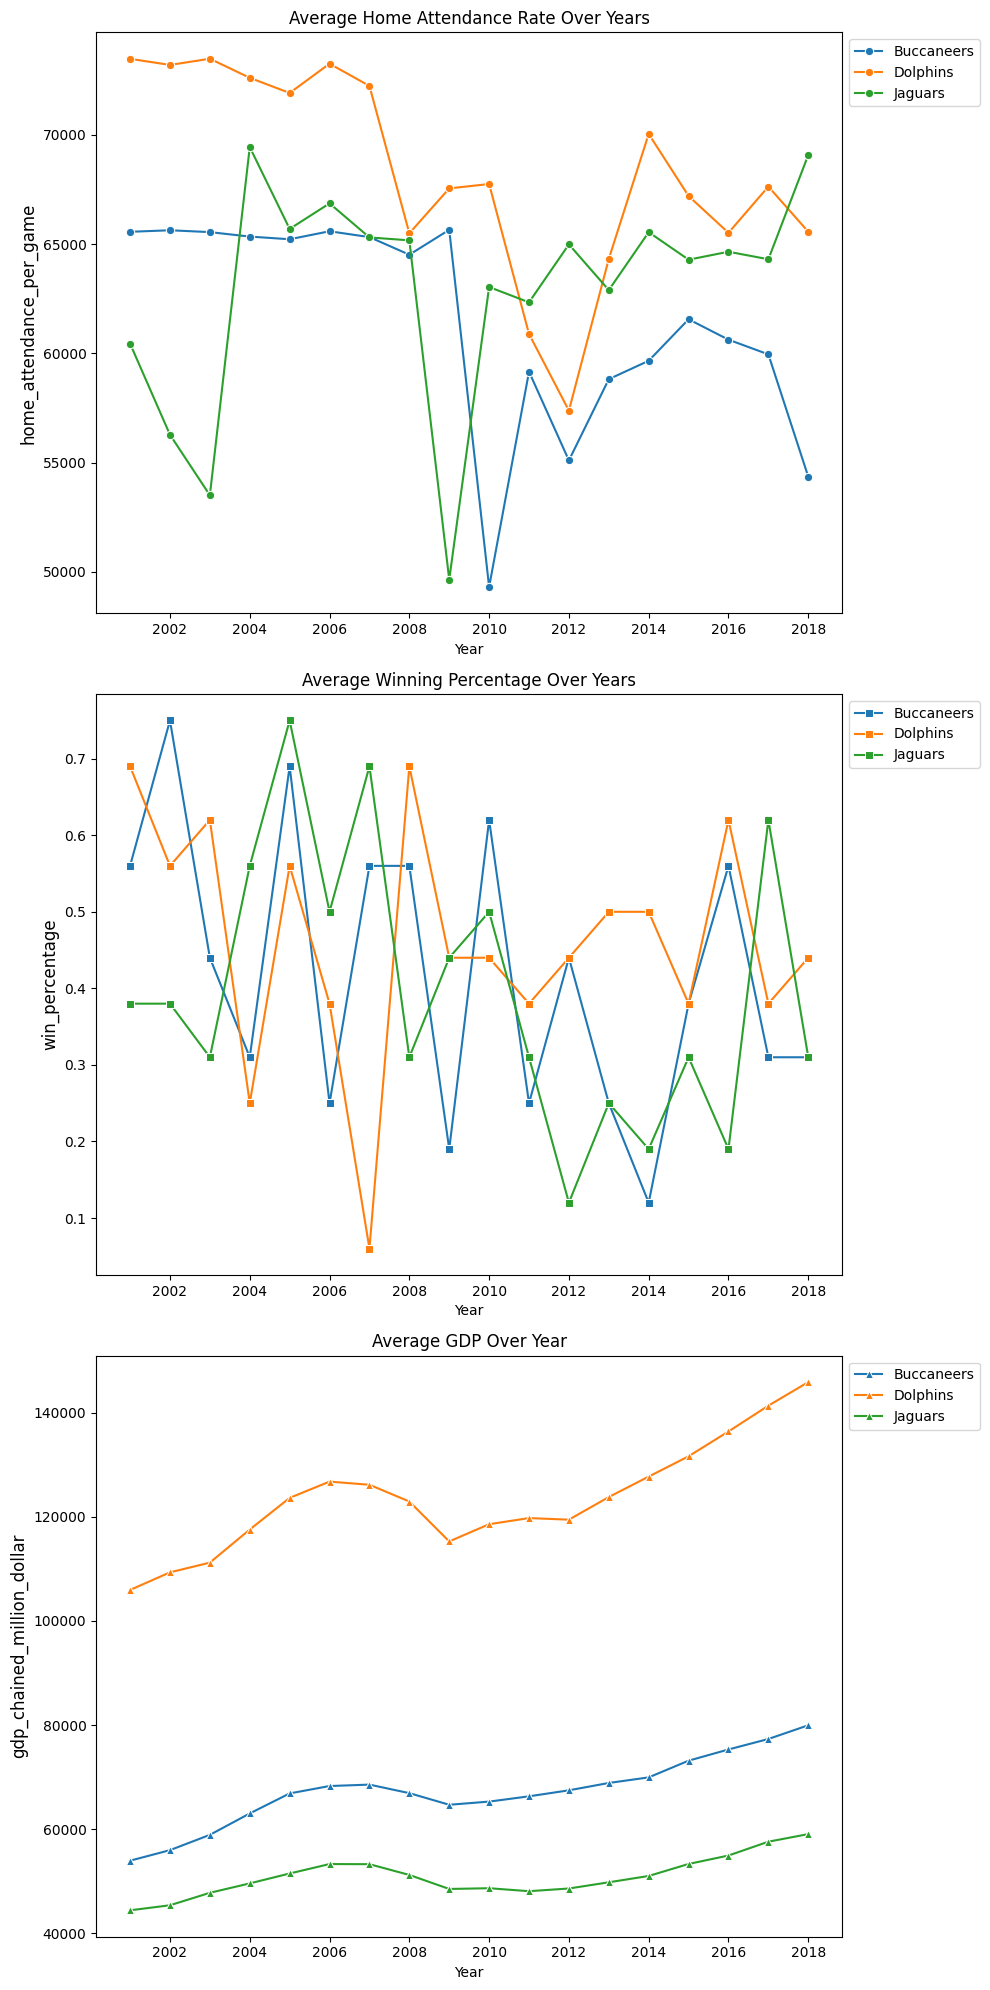

In [36]:
# Visualize the data
def plot_graphs(
    average_home_attendance_rate,
    average_winning_percentage,
    average_gdp,
):
    fig, ax = plt.subplots(3, 1, figsize=(10, 20))  # Increase figure size

    for axis in ax:
        axis.xaxis.set_major_locator(
            ticker.MaxNLocator(integer=True)
        )  # Referenced from GEN AI to set x-ticks to be integer values

    # Home Attendance Rate
    sns.lineplot(
        data=average_home_attendance_rate,
        x="year",
        y="home_attendance_per_game",
        hue="team_name",
        ax=ax[0],
        marker="o",
    )
    ax[0].set_title("Average Home Attendance Rate Over Years")
    ax[0].legend(loc="upper left", bbox_to_anchor=(1, 1))  # Move legend out of plot

    # Winning Percentage
    sns.lineplot(
        data=average_winning_percentage,
        x="year",
        y="win_percentage",
        hue="team_name",
        ax=ax[1],
        marker="s",
    )
    ax[1].set_title("Average Winning Percentage Over Years")
    ax[1].legend(loc="upper left", bbox_to_anchor=(1, 1))

    # GDP
    sns.lineplot(
        data=average_gdp,
        x="year",
        y="gdp_chained_million_dollar",
        hue="team_name",
        ax=ax[2],
        marker="^",
    )
    ax[2].set_title("Average GDP Over Year")
    ax[2].legend(loc="upper left", bbox_to_anchor=(1, 1))

    for axis in ax:
        axis.set_xlabel("Year")  # Set x-axis label
        axis.set_ylabel(
            axis.get_ylabel(), fontsize=12
        )  # Set y-axis label with larger font
        axis.tick_params(
            axis="both", which="major", labelsize=10
        )  # Set larger tick labels

    plt.tight_layout()
    plt.show()


# now call the function to plot the graphs
plot_graphs(
    average_home_attendance_rate,
    average_winning_percentage,
    average_gdp,
)

**Average Home Attendance Rate Over Years:**

- Buccaneers: While the Buccaneers’ attendance is generally high, there is a noticeable dip in attendance around 2010, indicating a period of lower fan turnout.

- Dolphins: The Dolphins’ attendance rate shows some ups and downs, with a couple of prominent peaks suggesting seasons of high fan interest. However, like the Buccaneers, they also experience a significant drop around 2007 and another dip after a peak in 2010.

- Jaguars: The Jaguars have the most dramatic shifts in attendance. They see a sharp decline around 2007, then a rapid increase, followed by another severe drop towards the end of the observed period.


**Average Winning Percentage Over years**

- Buccaneers: The Buccaneers' winning percentage shows significant variability from year to year. They start with a high winning percentage in the early 2000s, indicating a successful period, followed by a sharp decline. Their performance peaks again around 2005, dips, and then peaks around 2010 and again around 2015. This suggests a cyclical pattern of performance highs and lows.

- Dolphins: The Dolphins' trend line also displays variability, but without the highs of the Buccaneers. They experience a peak around 2008, which could indicate a particularly successful season, followed by inconsistent performance with a mix of ups and downs, indicating periods of both struggle and success.

- Jaguars: The Jaguars' winning percentage starts lower in the early 2000s but quickly peaks, suggesting a strong period of performance early on. This is followed by a sharp decline, a rise to another peak around 2007, and then a pattern of significant fluctuations. The sharp peak around 2017 stands out, suggesting a particularly successful season after a period of lower performance.

**Average GDP Over Years**

- Buccaneers: Buccaneers show the smallest growth but maintain a consistent upward trend.

- Dolphins: The Dolphins having the highest GDP, which increases significantly from around 100,000 million chained dollars to about 140,000 million chained dollars.

- Jaguars: The Jaguars show a moderate but steady increase in GDP


**Overall conclusion**
- The Buccaneers, Dolphins, and Jaguars each tell a different story of sports success, fan support, and economic growth. While the Buccaneers and Jaguars see their fan attendance and game wins go up and down, reflecting directly in their engagement levels, the Dolphins manage to make the most money despite not always shining on the field. This highlights a complex picture where winning isn't the only thing that matters; economic impact and fan loyalty also play crucial roles, with each team navigating these aspects in its unique way.

### Comparative Analysis 3: Team Metrics Comparison Grouped by Team ###

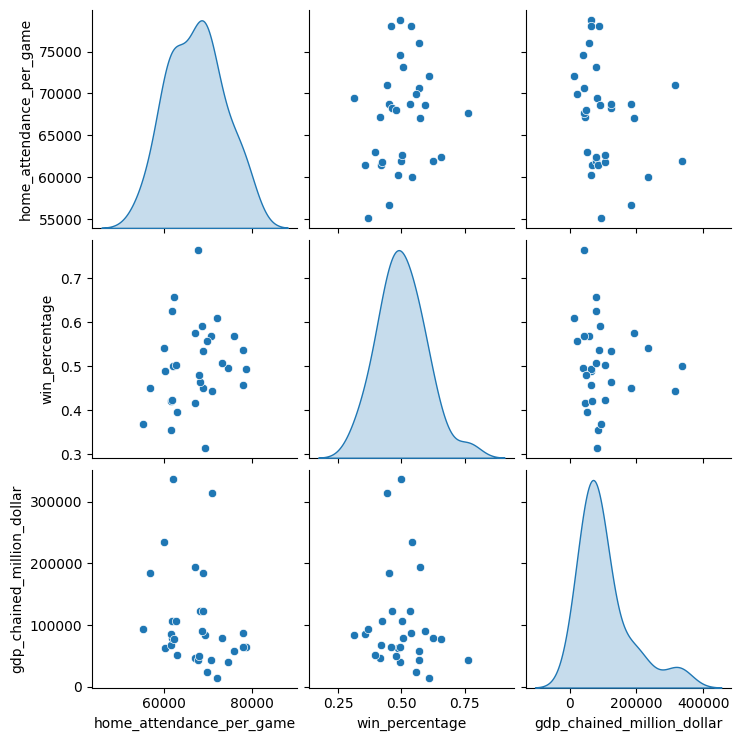

In [37]:
# groupby the team_name, calculating mean team_attendance,winning percentage, and GDP over year
team_attendance = (
    final_dataset.groupby("team_name")
    .agg(
        {
            "home_attendance_per_game": "mean",
            "win_percentage": "mean",
            "gdp_chained_million_dollar": "mean",
        }
    )
    .reset_index()
)
# create a pairplot showing the pairwise relationships and KDE distributions for these variables.
sns.pairplot(
    team_attendance,
    vars=["home_attendance_per_game", "win_percentage", "gdp_chained_million_dollar"],
    diag_kind="kde",
)
plt.show()

 The diagonal plots indicate the distribution of each variable individually, showing a spread of data points without a single, dominant peak. The off-diagonal scatter plots, meant to reveal any correlations between pairs of variables, do not display any discernible patterns or clear correlations. This suggests that, within the dataset's context, team game attendance, winning rates, and GDP do not have a straightforward or linear relationship with one another.

### Comparative Analysis 4: Team Metrics Comparison Grouped by Year ###

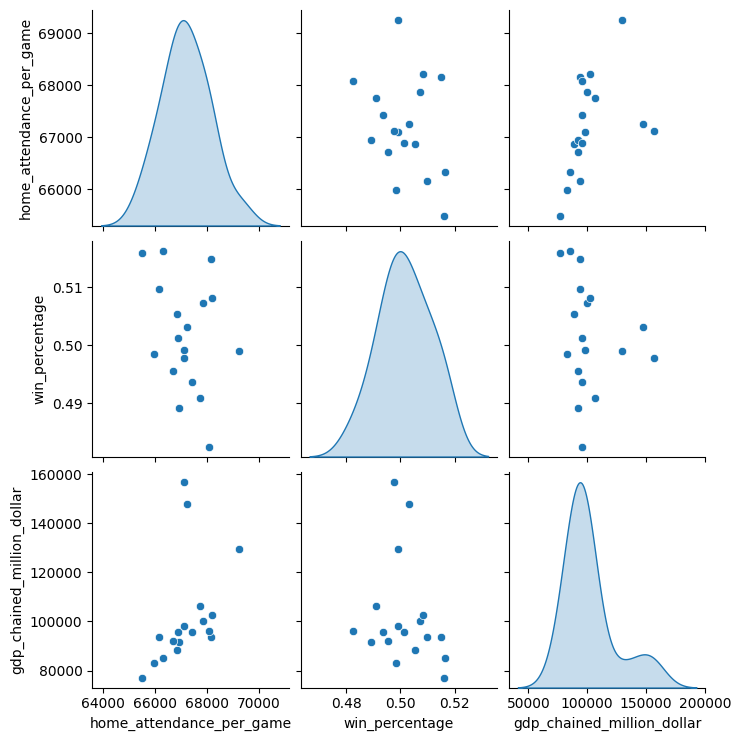

In [38]:
# group by year, calculating mean team attendance, winning percentage, and GDP over the years.
year = (
    final_dataset.groupby("year")
    .agg(
        {
            "home_attendance_per_game": "mean",
            "win_percentage": "mean",
            "gdp_chained_million_dollar": "mean",
        }
    )
    .reset_index()
)
# create a pairplot showing the pairwise relationships and KDE distributions for these variables.
sns.pairplot(
    year,
    vars=["home_attendance_per_game", "win_percentage", "gdp_chained_million_dollar"],
    diag_kind="kde",
)
plt.show()

There's a concentration of data around specific ranges for 'home_attendance_per_game' and 'gdp_chained_million_dollar', suggesting common values or ranges for these metrics across the dataset. However, 'win_percentage' appears to be fairly uniform. No obvious linear correlations are seen in the scatter plots, indicating that these variables do not strongly predict one another in a linear sense within this dataset.

## Multivariate Analysis

Perform multivariate analysis to understand the relationships among three or more variables in your dataset.

Use techniques like cross-tabulation, pivot tables, and multivariate graphs.


### Multivariate Analysis1 Multiple Regression

In [39]:
# mutiple regression model
model3 = smf.ols(
    "home_attendance_rate_per_game ~ C(win_percentage_category) + C(gdp_category) + C(renovated)",
    data=final_dataset,
).fit()

print(model3.summary())

                                  OLS Regression Results                                 
Dep. Variable:     home_attendance_rate_per_game   R-squared:                       0.045
Model:                                       OLS   Adj. R-squared:                  0.035
Method:                            Least Squares   F-statistic:                     4.592
Date:                           Tue, 19 Mar 2024   Prob (F-statistic):           0.000144
Time:                                   14:44:14   Log-Likelihood:                 637.54
No. Observations:                            589   AIC:                            -1261.
Df Residuals:                                582   BIC:                            -1230.
Df Model:                                      6                                         
Covariance Type:                       nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.

**Win Percentage Category**

- Teams categorized under "medium" and "high" win percentages show a significant positive effect on home attendance rates, with coefficients of 0.0349 and 0.0379. This suggests that as the win percentage increases from low to medium and high, there is a noticeable improvement in home attendance rates. The positive coefficients and their significance (P<0.05) highlight the importance of team performance in attracting spectators.

**GDP Category**

-  The GDP category shows a less clear impact on attendance rates. "High" GDP areas show a positive effect on attendance rates, indicated by a coefficient of 0.0171 with the P-value of 0.053. In contrast, "Medium" and "Very High" GDP categories have minimal impact on attendance, evidenced by their coefficients and insignificant P-values. It suggests that economic condition may contribute to higher attendance rates, but it is not a consistent factor across different levels of economic status.

**Stadium Renovation**

- The coefficient for renovated stadiums (0.0207) indicates a positive relationship between stadium renovation and attendance rates, albeit not statistically significant (P=0.280). This points to the possibility that renovated facilities might attract more spectators.

In [40]:
# create a cross-tabulation table for the win_percentage_category and the gdp_category and renovated
cross_tab = pd.crosstab(
    [final_dataset["win_percentage_category"], final_dataset["gdp_category"]],
    final_dataset["renovated"],
)
cross_tab

renovated                              0  1
win_percentage_category gdp_category       
low                     Low           57  0
                        Medium        65  0
                        High          67  1
                        Very High     60  4
medium                  Low           49  1
                        Medium        50  2
                        High          45  0
                        Very High     47  3
high                    Low           41  0
                        Medium        28  2
                        High          31  3
                        Very High     33  0

- Stadium renovations seem to be more common in higher GDP areas, suggesting a possible link between economic status and the ability or decision to renovate.

- There is not a strong correlation between win percentage and the likelihood of stadium renovation. This could imply that there exist other factors play a more significant role in renovation decisions.

- The presence of renovations across different combinations of win percentage and GDP categories suggests a complex decision-making process that likely incorporates multiple factors beyond just team success and local economy.

In [41]:
# create a pivot table to show the average home attendance rate for the teams in each winning percentage category and GDP category and renovation status
pivot_table = final_dataset.pivot_table(
    index="win_percentage_category",
    columns=["gdp_category", "renovated"],
    values="home_attendance_rate_per_game",
    aggfunc="mean",
)
pivot_table

gdp_category                  Low              Medium                High  \
renovated                       0         1         0         1         0   
win_percentage_category                                                     
low                      0.928378       NaN  0.939253       NaN  0.952608   
medium                   0.970116  1.038829  0.961558  0.970992  0.988425   
high                     0.978564       NaN  0.984147  0.932472  0.982057   

gdp_category                      Very High            
renovated                       1         0         1  
win_percentage_category                                
low                      0.941812  0.943762  0.967356  
medium                        NaN  0.973158  1.018525  
high                     1.039778  0.944211       NaN

**Impact of Renovations**

- Renovations seem to have a positive impact on attendance rates in most scenarios.

- In the "medium" win percentage category with "Low" GDP, renovated stadiums have a higher average attendance rate (1.038829) compared to non-renovated ones (0.970116).

- This suggests that improvements or updates to stadium facilities can enhance the fan experience, leading to higher attendance rates.

**Winning Percentage Influence**

- Across all GDP categories, there is a general trend where teams with a higher win percentage ("high") tend to have higher attendance rates than those with lower win percentages ("low" and "medium").

- This pattern reaffirms the intuitive understanding that better team performance typically attracts more spectators.

**GDP Influence**

- The "Very High" GDP category often shows high attendance rates. It indicates that teams located in economically prosperous areas might benefit from a larger pool of potential attendees who can afford to attend games.

- This effect appears to be clearer in teams with renovations, as seen in the "low" win percentage category, where the attendance rate jumps to 0.967356 with renovations.

**Renovations and GDP Interplay**

- The positive effect of stadium renovations on attendance is more evident in certain GDP categories.

- In the "medium" win percentage category, renovated stadiums in both the "Low" and "Very High" GDP areas show notably higher attendance rates than their non-renovated counterparts.

- This might suggest that the impact of renovations on increased attendance in areas with either economic challenges or advantages.

### Steps
- variables to analyze: home_attendance_rate_per_game, winning_percentage, gdp_chained_million$, renovated
- analysis: multiple regression, pivot tables, multivariate graphs.

## Synthesis

Synthesize the findings from your descriptive and inferential statistics along with your graphical analyses to answer your research questions.

Discuss how the combination of the datasets has provided added value in terms of insights or capabilities that would not be possible with the individual datasets in isolation.


## Here are the real world questions we will try to answer:
<ol>
<li>To what degree does the Gross Domestic Product (GDP) of a county correlate with the attendance figures of its local sports team?</li>
<li>How significantly does the performance of a sports team, as reflected by their win-loss record, affect their game attendance numbers?
<li>Does the renovation of the stadium increase the home attendance significantly?

From the descriptive statistics, we can infer that while the total home attendance varies a lot between different teams, the average home attendance rate shows a relatively low standard deviation. What's behind is the difference in stadium capacity of each team and strong fan engagement across the league. Win percentages hover around 0.50, indicating a competitive league. Economic output, measured by GDP, varies significantly among regions, with a mean of $79,552 million and a substantial range of $698,358 million. <br>
According to the inferential statistics and graphical analyses, we can answer our research questions as following:
1. The positive correlation between local gdp and the team's home attendance rate is very weak, and there is no significant effect of local gdp on home attendance rate.
2. The positive correlation between team performance and the team's home attendance rate is very weak, but there is there is a statistically significant relationship between the factors.
3. There is no significant effect of stadium renovation on home attendance rate.

## Documentation

Outline the steps you took in your analysis, providing the rationale for the choice of tools and techniques.

Clearly document your code, analyses, and interpretations so that they are understandable and reproducible.


### Steps
#### Descriptive Statistics
- Calculate the overall means, medians, modes, ranges, variance, and standard deviations of home_attendance, home_attendance_rate_per_game, win_percentage and gdp_chained_million_dollar of all teams.
- Calculate each team's means, medians, modes, ranges, variance, and standard deviations of home_attendance, home_attendance_rate_per_game, win_percentage and gdp_chained_million_dollar each year.
  - code used: aggregate functions

#### Inferential Statistics
- Simple linear regression between home_attendance_rate_per_game and win_percentage
- Anova Test between home_attendance_rate_per_game and win_percentage_category
- Anova Test between home_attendance_rate_per_game and gdp_category
- Chi-square Test between home_attendance_category and renovation
- Chi-square Test between home_attendance_category and superbowl_winner

#### Graphical Analysis
-  Regression plots of home_attendance_rate_per_game & win_percentage, boxplot of home_attendance_rate_per_game & win_percentage_category
-  Distribution of home_attendance_rate in different gdp categories

#### Comparative Analysis
- 

#### Multivariate Analysis
- multiple regression between home_attendance_rate_per_game and win_percentage_category, gdp_category, renovation
- cross-tabulation
- pivot table


## Reporting & Interpretation

Prepare markdown blocks that summarize your methodology, analysis, and findings.  You should intersperse these with your code.

Your notebook should be well-structured, with clear sections, headings, and subheadings.


## Reflection

Include a section (using one or more markdown blocks) at the end of your notebook in which you reflect on the process of analyzing the data. Discuss any challenges you encountered and how you overcame them.

Critically evaluate the limitations of your analysis and suggest areas for further research or improvement.
